# XGBoost training for lung cancer risk prediction

P. Benveniste $^1$, J. Alberge $^1$

$^1$ Ecole Normale Supérieure Paris-Saclay

In this Notebook, we describe the training of the XGBoost model and hyperparameter optimisation for lung cancer risk prediction using the PLCO and NLST screening trials. 

## Library import

**YOU NEED TO USE PYTHON 3.7-3.9**

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import time
from time import time
import shap
import pickle
import pprint
import numpy as np

# Model selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_recall_curve, precision_score
from sklearn.metrics import classification_report, confusion_matrix

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Integer

#Calibration
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

# Useful functions

In [76]:
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()

    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

# Lung cancer risk estimation

In this notebook, we will try to predict lung cancer based on two datasets: 
- PLCO dataset: with 150 000 points and 219 descriptors for each point
- NLST dataset : 50 000 points and 322 descriptors for each point

In [77]:
plco_file = './package-plco-594/Lung/lung_data_nov18_d070819.csv'
plco = pd.read_csv(plco_file)
plco_nb_ini = len(plco)
print(plco.shape)

nlst_file = './package-nlst-814.2021-07-27/participant_data_d100517.csv'
nlst = pd.read_csv(nlst_file)
nlst_nb_ini = len(nlst)
print(nlst.shape)

(154887, 219)


Columns (99,248,249) have mixed types. Specify dtype option on import or set low_memory=False.


(53452, 324)


## Removal of non-smokers

Because our target populations and because smoking is such a high contributing risk factor we decide to keep only the participants to PLCO who are smokers or former-smokers. Also, this removes a bias as our testing dataset NLST only contains smokers and former-smokers.

`cig_stat == 1 or 2`

In [78]:
print("Total number of participant to PLCO:",len(plco))
plco = plco.loc[plco.cig_stat > 0]
print("Numbers of smokers and former-smokers:",len(plco))

Total number of participant to PLCO: 154887
Numbers of smokers and former-smokers: 80668


## Censored data

Both our dataset contains subjects who are not interesting to our study. We decided to remove:

- Patients who died because of something else :

    Their case can add bias to the model as they might have been more susceptible of developping lung cancer because of having poor health
    
- Remove all who have not been followed enough through the study

    We will explain how the minimum reauired time was computed

In [79]:
#For PLCO
plco_nb = len(plco)
plco = plco.loc[plco['d_dthl']!=0]
plco_nb_aft = len(plco)
print("---- PLCO ----")
print("Removed "+ str(plco_nb - plco_nb_aft ))
print("Remaining "+str(plco_nb_aft))
print("Removed " + str(round((((plco_nb - plco_nb_aft)/plco_nb_ini)*100),2)) + " % of PLCO")

#For NLST
nlst_nb = len(nlst)
nlst = nlst.loc[nlst['finaldeathlc']!=0]
nlst_nb_aft = len(nlst)
print("---- NLST ----")
print("Removed "+ str(nlst_nb - nlst_nb_aft ))
print("Remaining "+str(nlst_nb_aft))
print("Removed " + str(round((((nlst_nb - nlst_nb_aft)/nlst_nb_ini)*100),2)) + " % of NLST")


---- PLCO ----
Removed 24356
Remaining 56312
Removed 15.73 % of PLCO
---- NLST ----
Removed 2904
Remaining 50548
Removed 5.43 % of NLST


Let's look at the distribution of the length of study of the patients to select a length which is appropriate for everyone.

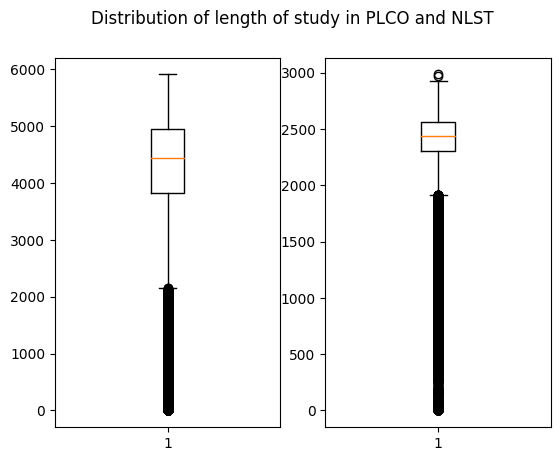

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution of length of study in PLCO and NLST ')
ax1.boxplot(plco['lung_exitdays'])
ax2.boxplot(nlst['fup_days'])
plt.show()

We only keep participant who were studied longer than 2100 days (5.75 years) if they were never diagnosed with cancer and those who were diagnosed with cancer when ever. On the other hand, we don't mind keeping participants who stayed longer as they bring more information to the study. 

In [81]:
plco_nb2 = len(plco)
plco = plco[((plco['lung_exitstat']!=1) & (plco['lung_exitdays']>2100)) | (plco['lung_exitstat']==1)]
plco_nb_final = len(plco)
print("---- PLCO ----")
print("Removed "+ str(plco_nb2 - plco_nb_final ))
print("Remaining "+str(plco_nb_final))
print("Removed " + str(round((((plco_nb2 - plco_nb_final)/plco_nb_ini)*100),2)) + " % of PLCO")

nlst_nb2 = len(nlst)
nlst = nlst[((nlst['scr_group']!=1) & (nlst['fup_days']>2100)) | (nlst['scr_group']==1)]
nlst_nb_final = len(nlst)
print("---- NLST ----")
print("Removed "+ str(nlst_nb2 - nlst_nb_final ))
print("Remaining "+str(nlst_nb_final))
print("Removed " + str(round((((nlst_nb2 - nlst_nb_final)/nlst_nb_ini)*100),2)) + " % of NLST")


---- PLCO ----
Removed 1151
Remaining 55161
Removed 0.74 % of PLCO
---- NLST ----
Removed 1953
Remaining 48595
Removed 3.65 % of NLST


## Pre-Processing


We first extract the same features from both dataset and keep only those which we have seen are risk factors related to lung cancer.

In both dataset, we can find different informations but the dataset may be not be in the same format or described the same descriptors. In the following we will use the name of the PLCO features.


For the race feature, On the PLCO dataset, we have: 

`
1="White, Non-Hispanic" 
2="Black, Non-Hispanic" 
3="Hispanic"
4="Asian"
5="Pacific Islander" 
6="American Indian" 
7="Missing"
`

And, for the NLST dataset, we have: 

`
1="White"
2="Black or African-American"
3="Asian"
4="American Indian or Alaskan Native"
5="Native Hawaiian or Other Pacific Islander" 
6="More than one race"
7="Participant refused to answer"
95="Missing data form - form is not expected to ever be completed"
96="Missing - no response"
98="Missing - form was submitted and the answer was left blank"
99="Unknown/ decline to answer"
`

So, we will keep: 

`
1="White or hispanic" 
2="Black" 
4="Asian"
5="Pacific Islander" 
6="American Indian" 
7="Missing"
`

In [82]:
#For PLCO
plco = plco[["age", "sex", "height_f", "weight_f", "race7", "ssmokea_f", "cig_stat", "cigar", "pipe", "pack_years", "smokea_f", "cigpd_f","cig_years", "bronchit_f",
                "diabetes_f", "emphys_f", "hearta_f", "hyperten_f", "stroke_f", "lung_fh","lung_cancer"
            ]]
plco["race7"] = plco["race7"].replace(3,1)
plco["lung_fh"] = plco["lung_fh"].replace(9,0)

print(plco.shape)

#For NLST
nlst2 = nlst[["age", "gender", "height",  "weight", "race", "age_quit", "cigsmok", "cigar", "pipe", "pkyr", "smokeage", "smokeday", "smokeyr", "agechro", "diagdiab",
        "diagemph", "diaghear", "diaghype", "diagstro",
        ]]
nlst2["lung_fh"] = nlst[["famfather","fammother", "famchild", "famsister", "fambrother"]].max(axis=1)
nlst2["can_scr"] = 1 * (nlst["can_scr"] > 0)
nlst2["race"] = nlst2["race"].replace([3,4,6,95,96,98,99],[4,6,7,7,7,7,7])
nlst2['cigsmok'] = nlst2["cigsmok"].replace(0,2)
nlst=nlst2
print(nlst.shape)

(55161, 21)
(48595, 21)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Now we change the column names to have two matching datasets.

In [83]:
change_columns = {
        "age": "age",
        "gender": "sex", 
        "height": "height_f",
        "weight": "weight_f",
        "race": "race7",
        "age_quit": "ssmokea_f",
        "cigsmok": "cig_stat",
        "cigar": "cigar",
        "pipe": "pipe",
        "pkyr": "pack_years",
        "smokeage": "smokea_f",
        "smokeday": "cigpd_f",
        "smokeyr": "cig_years",
        "agechro": "bronchit_f",
        "diagdiab": "diabetes_f",
        "diagemph": "emphys_f",
        "diaghear": "hearta_f",
        "diaghype": "hyperten_f",
        "diagstro": "stroke_f",
        "can_scr": "lung_cancer",
        "lung_fh": "lung_fh"
}
nlst = nlst.rename(columns=change_columns)

We add the `bmi` column by computing it from other columns. 

In [84]:
plco.loc[:, 'bmi'] = plco['weight_f'] / plco['height_f']**2 * 703
nlst['bmi'] = nlst['weight_f'] / nlst['height_f']**2 * 703

Finally, we extract the feature columns and the output column for both the training and testing sets.

In [85]:
x_plco = plco.drop(columns= ['lung_cancer'])
y_plco = plco['lung_cancer']
x_nlst = nlst.drop(columns=['lung_cancer'])
y_nlst = nlst['lung_cancer']

# MODEL 

To build a machine learning model able to predict the risk of lung cancer, we train an XGBoost on the pre-processed PLCO dataset. 
We then test the model on an external dataset: the NLST dataset.

Column to predict : lung_cancer

**Optimization**

Instead of doing a Grid Search to optimize our parameters, we will use a Package from scikit-learn named skopt. 

**Calibration**

To see if our models are calibrated, we will use a CVcalibration from the scikit learn package.

**Interpretability**

After doing all of this, we will try to interpret our model by looking at the Shapley Values. These will give us an idea of which features are the most important ones. 


In [86]:
x_train, x_val, y_train, y_val = train_test_split(x_plco, y_plco, test_size=0.3)
x_test,y_test = x_nlst, y_nlst

In [87]:
model_all_features = xgb.XGBClassifier(random_state=0, 
                        booster='gbtree', 
                        objective='binary:logistic', 
                        eval_metric='aucpr',
                        tree_method='exact')
model_all_features.fit(x_train, y_train)

y_val_pred = model_all_features.predict(x_val)
y_val_prob_pred = model_all_features.predict_proba(x_val)
print("---------- VALIDATION DATASET ------------")
print(classification_report(y_val,y_val_pred))
print("ROC AUC score validation", roc_auc_score(y_val, y_val_prob_pred[:, 1]))
print("F_1 score ", f1_score(y_val, y_val_pred))
print("Precision score ", precision_score(y_val, y_val_pred))
print("Recall score ", recall_score(y_val, y_val_pred))
print("PR AUC score  ", average_precision_score(y_val, y_val_pred))

y_test_pred = model_all_features.predict(x_test)
y_test_prob_pred = model_all_features.predict_proba(x_test)
print("---------- TESTING DATASET ------------")
print(classification_report(y_test,y_test_pred))
print("ROC AUC score validation", roc_auc_score(y_test, y_test_prob_pred[:, 1]))
print("F_1 score ", f1_score(y_test, y_test_pred))
print("Precision score ", precision_score(y_test, y_test_pred))
print("Recall score ", recall_score(y_test, y_test_pred))
print("PR AUC score  ", average_precision_score(y_test, y_test_pred))


---------- VALIDATION DATASET ------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15749
           1       0.40      0.07      0.12       800

    accuracy                           0.95     16549
   macro avg       0.68      0.53      0.55     16549
weighted avg       0.93      0.95      0.93     16549

ROC AUC score validation 0.790324385675281
F_1 score  0.11914893617021277
Precision score  0.4
Recall score  0.07
PR AUC score   0.07295739923862468
---------- TESTING DATASET ------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     47084
           1       0.08      0.11      0.09      1511

    accuracy                           0.93     48595
   macro avg       0.52      0.53      0.53     48595
weighted avg       0.94      0.93      0.94     48595

ROC AUC score validation 0.6582187468321258
F_1 score  0.08927568781583378
Precision score  0.07752315943442223
Re

We look at which features are important:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


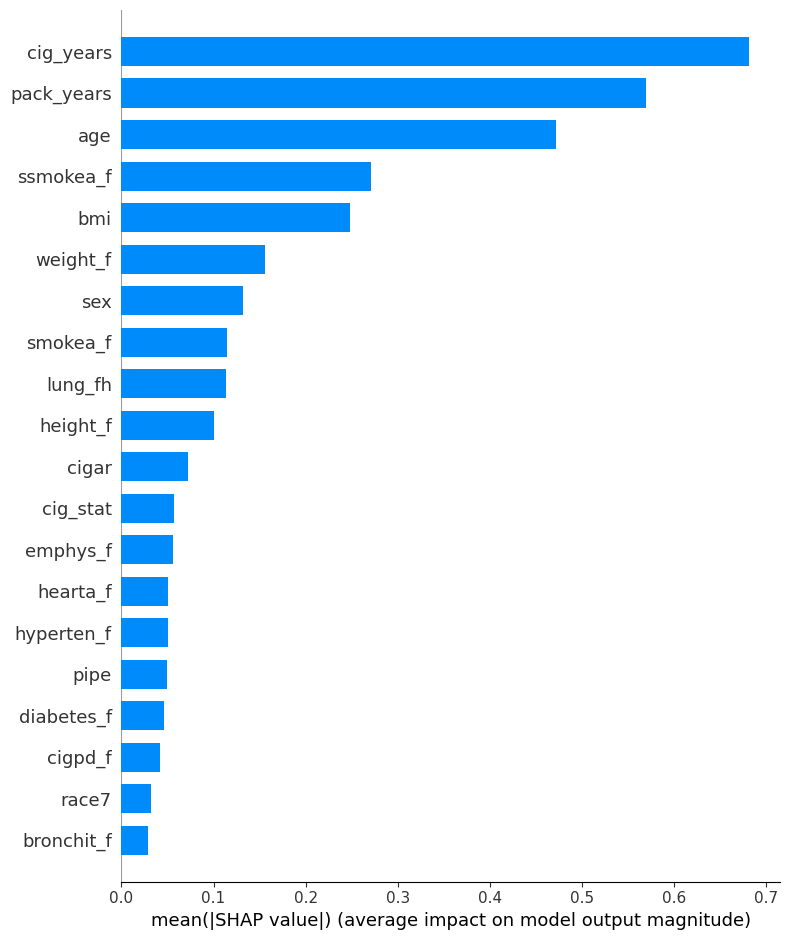

In [88]:
#To see importance over the entire dataset
shap_values = shap.Explainer(model_all_features).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

We then select the features to extract:

In [89]:
#Feature selection
columns_to_keep = ['age', 'ssmokea_f', 'cig_stat', 'pack_years', 'smokea_f', 
                  'cig_years', 'lung_fh', 'bmi'] 
x_plco = x_plco[columns_to_keep]
x_nlst = x_nlst[columns_to_keep]

x_train, x_val, y_train, y_val = train_test_split(x_plco, y_plco, test_size=0.3)
x_test,y_test = x_nlst, y_nlst

We now save the pre-processed data for further data analysis for the sake of the writing of the article. 

In [90]:
#For PLCO
final_plco = x_plco.copy()
final_plco['lung_cancer'] = y_plco.copy()
final_plco.to_csv('./preprocessed_plco.csv') 
#For NLST
final_nlst = x_nlst.copy()
final_nlst['lung_cancer'] = y_nlst.copy()
final_nlst.to_csv('./preprocessed_nlst.csv') 

print("Pre-processed data sets exported and saved!")

Pre-processed data sets exported and saved!


We now optimize the XGBoost model (commented in this case because already done)

In [91]:
#######
# Uncomment the following to perform hyperparameter optimisation
#######

# # Setting the basic regressor
# reg = xgb.XGBClassifier(random_state=0, 
#                         booster='gbtree', 
#                         objective='binary:logistic', 
#                         eval_metric='aucpr',
#                         tree_method='exact')

# # Setting the validation strategy
# skf = StratifiedKFold(n_splits=7,
#                       shuffle=True, 
#                       random_state=0)

# cv_strategy = list(skf.split(x_train, y_train))

# search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
#                  'max_depth': Integer(2, 10),
#                  'subsample': Real(0.1, 1.0, 'uniform'),
#                  'colsample_bytree': Real(0.1, 1.0, 'uniform'),
#                  'n_estimators': Integer(50, 1000),
#                  'reg_alpha': Real(0.001, 100., 'uniform'), 
#    }


# opt = BayesSearchCV(estimator=reg,                                    
#                     search_spaces=search_spaces,                                 
#                     cv=cv_strategy,                                           
#                     n_iter=300,                                       # max number of trials
#                     n_points=1,                                       # number of hyperparameter sets evaluated at the same time
#                     n_jobs=1,                                         # number of jobs
#                     iid=False,                                        # if not iid it optimizes on the cv score
#                     return_train_score=False,                         
#                     refit=False,                                      
#                     optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
#                     random_state=0)                                   # random state for replicability

# # Running the optimizer
# overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
# time_limit_control = DeadlineStopper(total_time=60*60*3)          # We impose a time limit (5 hours)

# best_params = report_perf(opt, x_train, y_train,'XGBoost_regression', 
#                           callbacks=[overdone_control, time_limit_control])



#######
# Comment the following to perform hyperparameter optimisation (this is the result of our optimisation)
#######

best_params = {'colsample_bytree': 0.3092626254072385,
             'learning_rate': 0.25090257611371497,
             'max_depth': 8,
             'n_estimators': 321,
             'reg_alpha': 18.11046009958031,
             'subsample': 0.3282432744048327
}

Now we train the model on the reduced list of features:

[0]	validation_0-aucpr:0.05140	validation_1-aucpr:0.05248
[1]	validation_0-aucpr:0.11519	validation_1-aucpr:0.11218
[2]	validation_0-aucpr:0.17062	validation_1-aucpr:0.16237


[3]	validation_0-aucpr:0.18303	validation_1-aucpr:0.17115
[4]	validation_0-aucpr:0.19606	validation_1-aucpr:0.18545
[5]	validation_0-aucpr:0.19793	validation_1-aucpr:0.18583
[6]	validation_0-aucpr:0.20432	validation_1-aucpr:0.19319
[7]	validation_0-aucpr:0.20480	validation_1-aucpr:0.19465
[8]	validation_0-aucpr:0.21262	validation_1-aucpr:0.19805
[9]	validation_0-aucpr:0.21399	validation_1-aucpr:0.19905
[10]	validation_0-aucpr:0.21977	validation_1-aucpr:0.20373
[11]	validation_0-aucpr:0.22132	validation_1-aucpr:0.20826
[12]	validation_0-aucpr:0.22260	validation_1-aucpr:0.21062
[13]	validation_0-aucpr:0.22339	validation_1-aucpr:0.21096
[14]	validation_0-aucpr:0.22471	validation_1-aucpr:0.21515
[15]	validation_0-aucpr:0.22504	validation_1-aucpr:0.21424
[16]	validation_0-aucpr:0.22510	validation_1-aucpr:0.21369
[17]	validation_0-aucpr:0.22523	validation_1-aucpr:0.21345
[18]	validation_0-aucpr:0.22574	validation_1-aucpr:0.21162
[19]	validation_0-aucpr:0.22569	validation_1-aucpr:0.21105
[20]

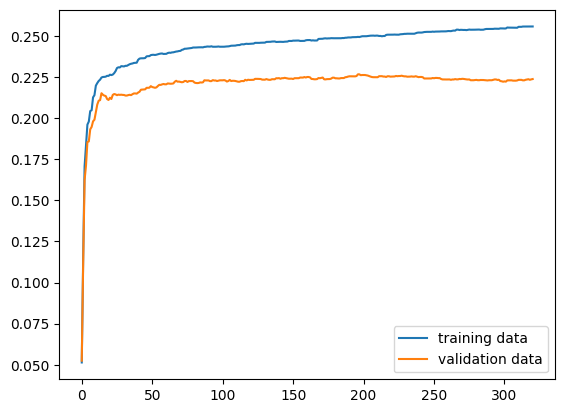

In [92]:
model_final = xgb.XGBClassifier(random_state=0, 
                        booster='gbtree', 
                        objective='binary:logistic', 
                        eval_metric='aucpr',
                        tree_method='exact',
                        **best_params)
model_final.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_val, y_val)])

train_history = model_final.evals_result()

plt.plot(train_history["validation_0"]["aucpr"], label="training data")
plt.plot(train_history["validation_1"]["aucpr"], label="validation data")
plt.legend()
plt.show()

Let's look at the results of the model

In [93]:
y_val_pred = model_final.predict(x_val)
y_val_prob_pred = model_final.predict_proba(x_val)
print("---------- VALIDATION DATASET ------------")
print(classification_report(y_val,y_val_pred))
print("ROC AUC score validation", roc_auc_score(y_val, y_val_prob_pred[:, 1]))
print("F_1 score ", f1_score(y_val, y_val_pred))
print("Precision score ", precision_score(y_val, y_val_pred))
print("Recall score ", recall_score(y_val, y_val_pred))
print("Brier score ", brier_score_loss(y_val, y_val_prob_pred[:,1]))
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
print("AUC-PR score  ", auc(recall, precision))
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
print("TP: " + str(tp) + ", FP: " + str(fp)+ ", TN: " + str(tn) + ", FN: " + str(fn) + "\n")


y_test_pred = model_final.predict(x_test)
y_test_prob_pred = model_final.predict_proba(x_test)
print("---------- TESTING DATASET ------------")
print(classification_report(y_test,y_test_pred))
print("ROC AUC score validation", roc_auc_score(y_test, y_test_prob_pred[:, 1]))
print("F_1 score ", f1_score(y_test, y_test_pred))
print("Precision score ", precision_score(y_test, y_test_pred))
print("Recall score ", recall_score(y_test, y_test_pred))
print("Brier score ", brier_score_loss(y_test, y_test_prob_pred[:,1]))
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
print("AUC-PR score  ", auc(recall, precision))
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
print("TP: " + str(tp) + ", FP: " + str(fp)+ ", TN: " + str(tn) + ", FN: " + str(fn))

---------- VALIDATION DATASET ------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15712
           1       0.52      0.02      0.03       837

    accuracy                           0.95     16549
   macro avg       0.73      0.51      0.50     16549
weighted avg       0.93      0.95      0.93     16549

ROC AUC score validation 0.8217334056019097
F_1 score  0.03464203233256351
Precision score  0.5172413793103449
Recall score  0.017921146953405017
Brier score  0.043272204767465586
AUC-PR score   0.2924166006145023
TP: 15, FP: 14, TN: 15698, FN: 822

---------- TESTING DATASET ------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     47084
           1       0.14      0.04      0.07      1511

    accuracy                           0.96     48595
   macro avg       0.56      0.52      0.52     48595
weighted avg       0.94      0.96      0.95     48595

ROC AUC score

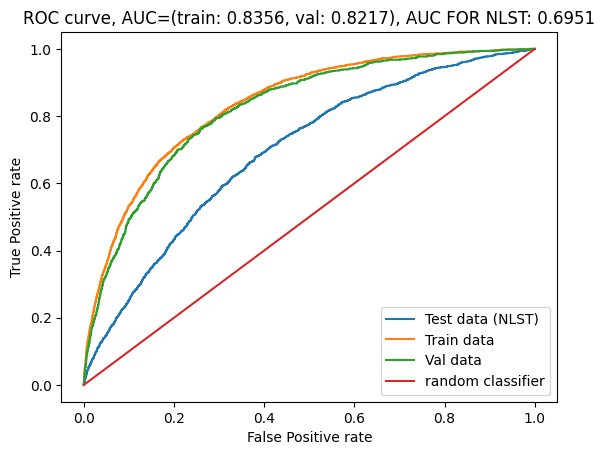

In [94]:
y_train_pred = model_final.predict_proba(x_train)
y_val_pred = model_final.predict_proba(x_val)
y_test_pred = model_final.predict_proba(x_test)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred[:, 1])
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred[:, 1])
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred[:, 1])

auc_test = auc(fpr_test, tpr_test)
auc_val = auc(fpr_val, tpr_val)
auc_train = auc(fpr_train, tpr_train)

plt.title(f"ROC curve, AUC=(train: {auc_train:.4f}, val: {auc_val:.4f}), AUC FOR NLST: {auc_test:.4f}")
plt.plot(fpr_test, tpr_test, label="Test data (NLST)")
plt.plot(fpr_train, tpr_train, label="Train data")
plt.plot(fpr_val, tpr_val, label="Val data")
plt.plot([0, 1], [0,1], label="random classifier")
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.show()

We now look at the precision recall curve on the entirety of PLCO. 

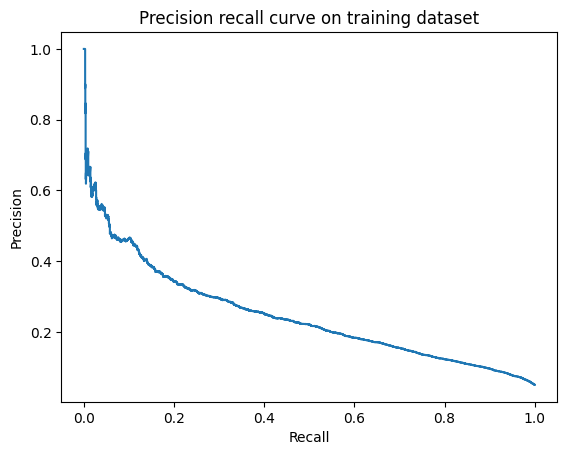

In [95]:
probs_plco = model_final.predict_proba(x_plco)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_plco, probs_plco)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision recall curve on training dataset")
plt.show()


We now select the precision value to compare with USPSTF at equal recall for PLCO.  

In [96]:
probs_plco = model_final.predict_proba(x_plco)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_plco, probs_plco)
#Selection of precision for fixed recall and extraction of threshold
recall_value_plco = 0.765
df = pd.concat([pd.DataFrame(precision, columns=['precision']), 
           pd.DataFrame(recall,columns=['recall']), 
           pd.DataFrame(thresholds,columns=['thresholds'])], axis=1)
max_precision_plco = df.loc[df['recall'] >= recall_value_plco].precision.max() 

print(" --- For PLCO ---")
print("For recall = " + str(round(recall_value_plco,3))  + " precision is : " + str(round(max_precision_plco,3)) )

#Compute confusion matrix with these parameters:
threshold_plco = float(df.loc[df['precision'] == max_precision_plco].thresholds)
preds_thresh_plco = np.where(probs_plco >= threshold_plco, 1, 0)
tn_plco, fp_plco, fn_plco, tp_plco = confusion_matrix(y_plco, preds_thresh_plco).ravel()
print("TP: " + str(tp_plco) + ", FP: " + str(fp_plco)+ ", TN: " + str(tn_plco) + ", FN: " + str(fn_plco) + "\n")

 --- For PLCO ---
For recall = 0.765 precision is : 0.134
TP: 2106, FP: 13658, TN: 38751, FN: 646



Now, we do the same for NLST.

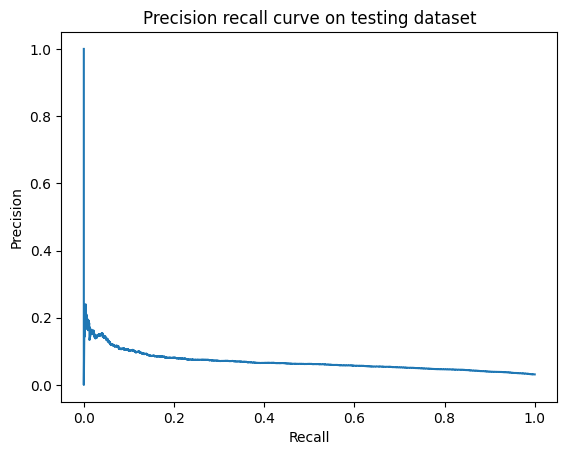

In [97]:
probs_nlst = model_final.predict_proba(x_nlst)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_nlst, probs_nlst)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision recall curve on testing dataset")
plt.show()


We now select the precision value to compare with USPSTF at equal recall. 

In [98]:
probs_nlst = model_final.predict_proba(x_nlst)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_nlst, probs_nlst)
#Selection of precision for fixed recall
recall_value_nlst = 0.989

df = pd.concat([pd.DataFrame(precision, columns=['precision']), 
           pd.DataFrame(recall,columns=['recall']), 
           pd.DataFrame(thresholds,columns=['thresholds'])], axis=1)
max_precision_nlst = df.loc[df['recall'] >= recall_value_nlst].precision.max()

print(" --- For NLST --- ")
print("For recall = " + str(round(recall_value_nlst,3)) + " precision is : " + str(round(max_precision_nlst,3)) )

#Compute confusion matrix with these parameters:
threshold_nlst = float(df.loc[df['precision'] == max_precision_nlst].thresholds)
preds_thresh_nlst = np.where(probs_nlst  >= threshold_nlst, 1, 0)
tn_nlst, fp_nlst, fn_nlst, tp_nlst = confusion_matrix(y_nlst, preds_thresh_nlst).ravel()
print("TP: " + str(tp_nlst) + ", FP: " + str(fp_nlst)+ ", TN: " + str(tn_nlst) + ", FN: " + str(fn_nlst) + "\n")

 --- For NLST --- 
For recall = 0.989 precision is : 0.032
TP: 1495, FP: 44808, TN: 2276, FN: 16



### Calibration

Here we look at the calibration curve:

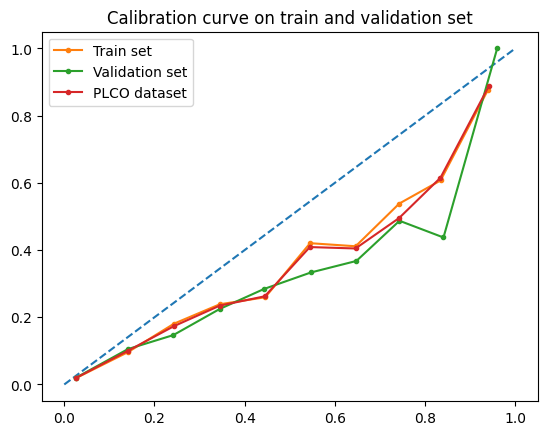

In [99]:
# predict probabilities
probs_train = model_final.predict_proba(x_train)[:, 1]
probs_val = model_final.predict_proba(x_val)[:, 1]
probs_plco = model_final.predict_proba(x_plco)[:, 1]
# reliability diagram
fop_train, mpv_train = calibration_curve(y_train, probs_train, n_bins=10, normalize=True)
fop_val, mpv_val = calibration_curve(y_val, probs_val, n_bins=10, normalize=True)
fop_plco, mpv_plco = calibration_curve(y_plco, probs_plco, n_bins=10, normalize=True)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv_train, fop_train, marker='.', label='Train set')
plt.plot(mpv_val, fop_val, marker='.', label='Validation set')
plt.plot(mpv_plco, fop_plco, marker='.', label='PLCO dataset')
plt.title("Calibration curve on train and validation set")
plt.legend()
plt.show()

We now calibrate the XGBoost model over the plco dataset and see how it does on the NLST dataset

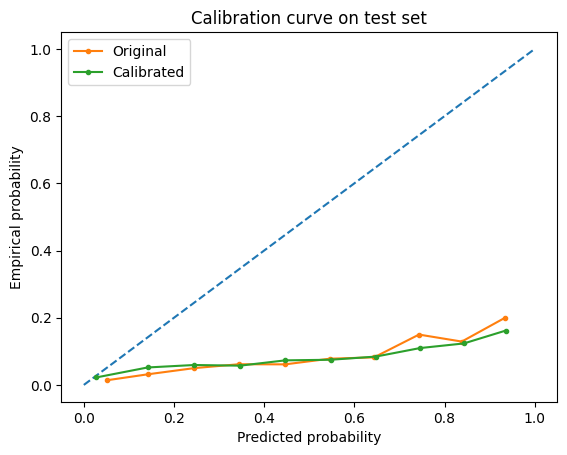

In [100]:
#reliability on the NLST dataset (using only the training set)
probs = model_final.predict_proba(x_test)[:, 1]
fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)

#Now with calibration on the NLST dataset using the PLCO validation set
calibrated = CalibratedClassifierCV(model_final, method='sigmoid', cv=5)
calibrated.fit(x_plco, y_plco)
probs_calib = calibrated.predict_proba(x_test)[:, 1]
fop_calib, mpv_calib = calibration_curve(y_test, probs_calib, n_bins=10, normalize=True)

#Relianility diagram
plt.title('Calibration curve on test set')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel("Empirical probability")
plt.xlabel("Predicted probability")
plt.plot(mpv, fop, marker='.',label='Original')
plt.plot(mpv_calib, fop_calib, marker='.',label='Calibrated')
plt.legend()
plt.show()

### Explainability

We can also view the explainability of each predictions based on the following code:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


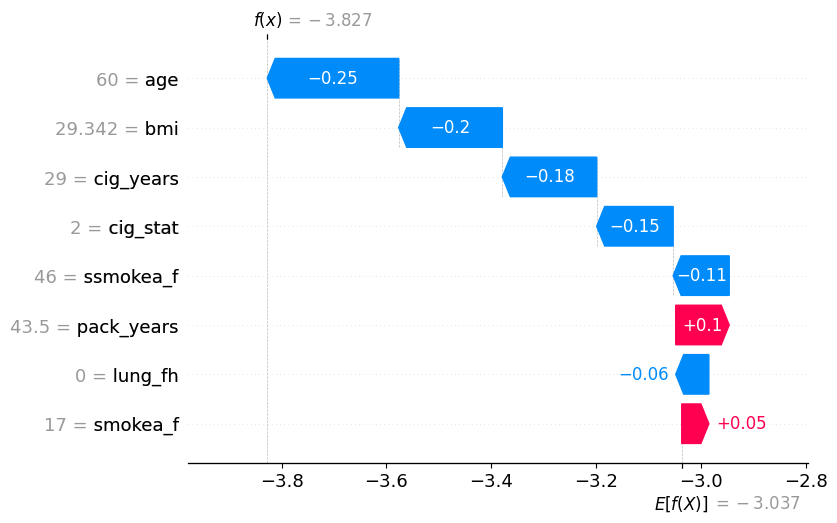

In [101]:
model_final.fit(x_train, y_train)
explainer = shap.Explainer(model_final)
shap_values = explainer(x_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[4])

### Saving of the model

We now save and compress the finally trained model in a pickle file.

In [102]:
pickle.dump(model_final, open('./model_lung_cancer.pkl', 'wb'))